In [0]:
import os
import sys
os.environ['SPARK_HOME'] ='/content/spark'
os.environ['JAVA_HOME'] ='/usr/lib/jvm/java-8-openjdk-amd64'

In [0]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [0]:
#for pseudo-cluster set-up
sc = SparkContext()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

# Loading in from bucket

In [0]:
import findspark
findspark.init()

In [0]:
thebucket="s3://6007.finalproject/devicestatus.txt"

In [0]:
import re

pattern="[\/|]"
substitute=","

##splits samples by newline, then by commas, then takes the first two and last two values.
devicestatus = sc.textFile(thebucket).\
flatMap(lambda x: x.split("\n"))\
.map(lambda x: re.sub(pattern,substitute,x))\
.map(lambda x: x.split(","))\
.map(lambda x: (x[0],x[1],x[-2],x[-1]))\
.filter(lambda x: type(x[-2]==float) and type(x[-1]==float))\
.map(lambda x: (float(x[-2]),float(x[-1]),x[0],x[1].split()))\
.map(lambda x: (x[0],x[1],x[2],x[3][0],x[3][1]))\
.filter(lambda x: x[0]!=0 and x[1]!=0)

In [0]:
devicestatus.take(3)

[(33.6894754264, -117.543308253, '2014-03-15:10:10:20', 'Sorrento', 'F41L'),
 (37.4321088904, -121.485029632, '2014-03-15:10:10:20', 'MeeToo', '1.0'),
 (39.4378908349, -120.938978486, '2014-03-15:10:10:20', 'MeeToo', '1.0')]

In [0]:
from pyspark.sql import types
ds_df = spark.createDataFrame(devicestatus, schema=types.StructType([\
                                                        types.StructField('latitude', types.FloatType(),True),
                                                        types.StructField('longtitude', types.FloatType(),True),
                                                        types.StructField('datestr', types.StringType(),True),
                                                        types.StructField('manufacturer', types.StringType(),True),
                                                        types.StructField('model_name', types.StringType(),True)
]))

In [0]:
from  pyspark.sql.functions import col,unix_timestamp, from_unixtime

df = ds_df.withColumn('date', 
                   from_unixtime(unix_timestamp(col('datestr'), 'yy-MM-dd:HH:mm:ss').alias('date')))
df = df.select(df.latitude,df.longtitude,df.date,df.manufacturer,df.model_name)

In [0]:
output_bucket="s3://6007.finalproject/parsed_data"

In [0]:
df.rdd.coalesce(1).saveAsTextFile(output_bucket)

In [0]:
sc.textFile(output_bucket).take(10)

["Row(latitude=33.689476013183594, longtitude=-117.54330444335938, date='2014-03-15 10:10:20', manufacturer='Sorrento', model_name='F41L')",
 "Row(latitude=37.43210983276367, longtitude=-121.48503112792969, date='2014-03-15 10:10:20', manufacturer='MeeToo', model_name='1.0')",
 "Row(latitude=39.437889099121094, longtitude=-120.93898010253906, date='2014-03-15 10:10:20', manufacturer='MeeToo', model_name='1.0')",
 "Row(latitude=39.36351776123047, longtitude=-119.40033721923828, date='2014-03-15 10:10:20', manufacturer='Sorrento', model_name='F41L')",
 "Row(latitude=33.19135665893555, longtitude=-116.4482421875, date='2014-03-15 10:10:20', manufacturer='Ronin', model_name='Novelty')",
 "Row(latitude=33.834354400634766, longtitude=-117.33000183105469, date='2014-03-15 10:10:20', manufacturer='Sorrento', model_name='F41L')",
 "Row(latitude=37.380393981933594, longtitude=-121.84075927734375, date='2014-03-15 10:10:20', manufacturer='Sorrento', model_name='F33L')",
 "Row(latitude=34.18410491

In [0]:
lat_long = devicestatus.map(lambda x: (x[0],x[1]))
lat_long = lat_long.collect()

In [0]:
import numpy as np
lat_long = np.array(lat_long)

In [0]:
!sudo python3 -m pip install matplotlib

    100% |████████████████████████████████| 12.4MB 108kB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 10.4MB/s ta 0:00:01
You are using pip version 9.0.3, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


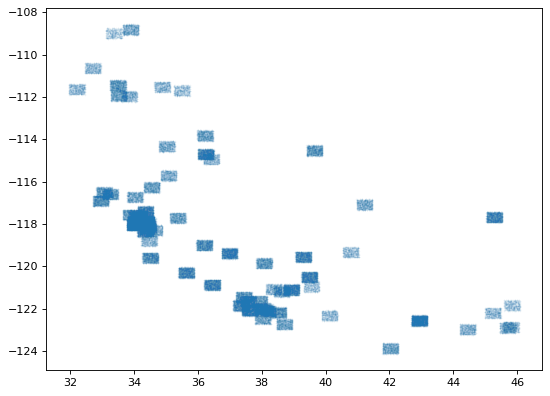

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(lat_long[:,0],lat_long[:,1],alpha=.2,marker='o',s=.03)
plt.show()